In [8]:
#@title All needed imports { display-mode: "form" }
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Conv2DTranspose, Reshape, Activation, BatchNormalization, GlobalAvgPool2D
import tensorflow as tf
import time
import urllib
import IPython
import tqdm.notebook as note

In [9]:
#@title Prevent Auto-Disconnect { display-mode: "form" }
#@markdown using javascript to always reconnect (at least during 6-12 hrs)

js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)

<IPython.core.display.Javascript object>

In [10]:
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
category = 'candle'

#@title Download images { display-mode: "form" }
#@markdown Creates a folder to download the original drawings into. <br> <br>
#@markdown We chose to use the numpy format: <br> 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')
images = np.load(f'npy_files/{category}.npy')

#@markdown <br> We have **141545** images to train on.
dataset_size = len(images)

In [11]:
#@title Discriminator { display-mode: "form" }
class Discriminator(tf.keras.Model):

    def __init__(self, DROPOUT_AMOUNT=0.2):
        super(Discriminator, self).__init__()
        self.lyrs = [
                     # block 1
                     Conv2D(
                         filters=32, kernel_size=3, strides=2, 
                         padding="same", activation="leaky_relu",
                         name='d_conv_1', kernel_regularizer="l2"),
                     MaxPooling2D((2, 2), padding='same'),
                     Dropout(DROPOUT_AMOUNT, name="d_dropout"),
                     
                     # block 2
                     Conv2D(
                         filters=64, kernel_size=3, strides=2, 
                         padding="same", activation="leaky_relu",
                         name='d_conv_1', kernel_regularizer="l2"),
                     MaxPooling2D((2, 2), padding='same'),
                     Dropout(DROPOUT_AMOUNT, name="d_dropout"),

                     Conv2D(
                         filters=128, kernel_size=3, strides=2, 
                         padding="same", activation="leaky_relu",
                         name='d_conv_1', kernel_regularizer="l2"),
                     Dropout(DROPOUT_AMOUNT, name="d_dropout"),

                     # flatten
                     GlobalAvgPool2D(),
                     # applying bottleneck (binary classification)
                     tf.keras.layers.Dense(units=1, activation="sigmoid", name='d_output_layer')
                     ]
    @tf.function
    def call(self, data, training=True):
        d = data
        for l in self.layers:
            if training or l.name != "d_dropout":
                d = l(d)
        return d

In [12]:
#@title Generator { display-mode: "form" }
class Generator(tf.keras.Model):

    def __init__(self, DROPOUT_AMOUNT=0.2, N_FAKE_DATA=100):
        super(Generator, self).__init__()
        self.lyrs = [
                     # block 1
                     Dense(7*7*128, use_bias=False, input_shape=(N_FAKE_DATA,),
                           name='g_input_layer', kernel_regularizer="l2"),
                     BatchNormalization(name='g_input_bn'),
                     Activation("leaky_relu"),
                     Reshape((7,7,128), name='reshape_Layer'),
                     Dropout(DROPOUT_AMOUNT, name="g_dropout"),
                    
                     # block 2
                     Conv2DTranspose(
                         filters=64, kernel_size=4, strides=1,
                         padding="same", name='g_conv_1',
                         kernel_regularizer="l2"),
                     BatchNormalization(name='g_bn_1'),
                     Activation("leaky_relu"),
                     Dropout(DROPOUT_AMOUNT, name="g_dropout"),

                     # block 3
                     Conv2DTranspose(
                         filters=32, kernel_size=4, strides=2,
                         padding="same", name='g_conv_1',
                         kernel_regularizer="l2"),
                     BatchNormalization(name='g_bn_1'),
                     Activation("leaky_relu"),
                     Dropout(DROPOUT_AMOUNT, name="g_dropout"),
                    
                     # block 5
                     Conv2DTranspose(
                         filters=1, kernel_size=4, strides=2, padding="same",
                         activation='tanh', name='g_output_layer')
                     ]
    @tf.function
    def call(self, data, training=True):
        d = data
        for l in self.layers:
            if training or l.name != "g_dropout":
                d = l(d)
        return d

In [13]:
#@title GAN { display-mode: "form" }
class GAN():

    def __init__(self, BATCH_SIZE=32, LEARNING_RATE=0.0001, DROPOUT_AMOUNT=0.2):
        self.G = Generator(DROPOUT_AMOUNT, N_FAKE_DATA)
        self.D = Discriminator(DROPOUT_AMOUNT)
        self.G_optimizer = tf.optimizers.Adam(LEARNING_RATE)
        self.D_optimizer = tf.optimizers.Adam(LEARNING_RATE)
        self.loss = tf.keras.losses.BinaryCrossentropy()
        self.batch_size = BATCH_SIZE
        self.summary_writer_train = tf.summary.create_file_writer(f"drive/MyDrive/Tensorflow/Week09/eval_logs/train")
        self.summary_writer_test = tf.summary.create_file_writer(f"drive/MyDrive/Tensorflow/Week09/eval_logs/test")


    def training_step(self, train_data, N_FAKE_DATA=100):
        z = tf.random.normal((self.batch_size, N_FAKE_DATA))

        with tf.GradientTape() as G_Tape, tf.GradientTape() as D_Tape:
            
            fake_data = self.G(z)
            fake_discriminated = self.D(fake_data)
            real_discriminated = self.D(train_data)
            
            G_loss_train = self.loss(fake_discriminated, tf.ones_like(fake_discriminated))
            D_fake_loss = self.loss(fake_discriminated, tf.zeros_like(fake_discriminated))
            D_real_loss = self.loss(real_discriminated, tf.ones_like(real_discriminated))
            D_loss_train = D_fake_loss + D_real_loss
            
            D_gradients = D_Tape.gradient(D_loss_train, self.D.trainable_variables)
            self.D_optimizer.apply_gradients(zip(D_gradients, self.D.trainable_variables))
            G_gradients = G_Tape.gradient(G_loss_train, self.G.trainable_variables)
            self.G_optimizer.apply_gradients(zip(G_gradients, self.G.trainable_variables))

        return np.array([G_loss_train, D_loss_train])


    def test(self, test_data, N_FAKE_DATA=100):
        z = tf.random.normal((self.batch_size,N_FAKE_DATA))
        G_loss_agg = np.empty(len(test_data))
        D_loss_agg = np.empty(len(test_data))

        fake_data = 0

        for i,d in enumerate(note.tqdm(test_data,position=0,leave=True)):

            fake_data = self.G(z, training=False)

            fake_discriminated = self.D(fake_data, training=False)
            real_discriminated = self.D(d, training=False)

            G_loss_test = self.loss(fake_discriminated, tf.ones_like(fake_discriminated))
            D_fake_loss = self.loss(fake_discriminated, tf.zeros_like(fake_discriminated))
            D_real_loss = self.loss(real_discriminated, tf.ones_like(real_discriminated))
            D_loss_test = D_fake_loss + D_real_loss
            
            G_loss_agg[i] = G_loss_test
            D_loss_agg[i] = D_loss_test
        
        G_loss_test = np.mean(G_loss_agg)
        D_loss_test = np.mean(D_loss_agg)

        return np.array([G_loss_test, D_loss_test]), fake_data


    def train(self, train_data, test_data, N_EPOCHS=10, N_FAKE_DATA=100):

        start_time = time.time()

        for e in range(N_EPOCHS):

            epoch_loss_agg = np.empty(len(train_data), dtype=object)
            for i,d in enumerate(note.tqdm(train_data, position=0, leave=True)):
                epoch_loss_agg[i] = self.training_step(d, N_FAKE_DATA)

            with self.summary_writer_train.as_default():
                for val,name in zip(np.mean(epoch_loss_agg, axis=0), ["Generator Loss","Discriminator Loss"]):
                    tf.summary.scalar(name, val, step=e)
            print(" Generator loss: ",np.mean(epoch_loss_agg,axis=0)[0],"\n","Discriminator loss: ",np.mean(epoch_loss_agg,axis=0)[1])
            
            with self.summary_writer_test.as_default():
                test_losses, generated_images = self.test(test_data, N_FAKE_DATA)
                for val,name in zip(test_losses, ["Generator Loss","Discriminator Loss"]):
                    tf.summary.scalar(name, val, step=e)
            
                tf.summary.image("Generated images", data=generated_images, max_outputs=self.batch_size, step=e)
                
            plt.imshow(generated_images.numpy()[np.random.randint(0, self.batch_size)].reshape(28,28))
            plt.show()
            
            used_time = np.round(time.time() - start_time)
            print(f"Finished epoch {e + 1} in {int(used_time // 60)} minutes and {int(used_time % 60)} seconds.")
            start_time = time.time()

In [14]:
#@title Define Hyperparameters { display-mode: "form" }

# Hyperparams
#@markdown Dataset split
train_size = 10000 #@param {type: "number"}
test_size = 1000 #@param {type: "number"}
#@markdown Dataset preprocessing
BATCH_SIZE =  32#@param {type: "number"}
SHUFFLE_SIZE = 100 #@param {type: "number"}
PREFETCH_SIZE=100 #@param {type: "number"}
#@markdown Training
LEARNING_RATE = 0.0001 #@param {type: "number"}
N_EPOCHS =  10#@param {type: "number"}
DROPOUT_AMOUNT = 0.2 #@param {type: "number"}
N_FAKE_DATA = 100 #@param {type: "number"}

train_images = images[:train_size]
test_images = images[train_size:train_size+test_size]

def np_to_preprocessed_ds(np_array, SHUFFLE_SIZE=1000, BATCH_SIZE=32, PREFETCH_SIZE=1000):
    min_val = np.amin(np_array)
    max_val = np.amax(np_array)
    ds = tf.data.Dataset.from_tensor_slices(np_array)
    ds = ds.map(lambda x: tf.reshape(x, (28,28,1)))
    ds = ds.map(lambda x: tf.cast(x,tf.float32)/128 -1)
    return ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

train_ds = np_to_preprocessed_ds(train_images, BATCH_SIZE)
test_ds = np_to_preprocessed_ds(test_images, BATCH_SIZE)
print(f'Train set: {train_ds}')
print(f'Test set: {test_ds}')

try: 
    %reload_ext tensorboard 
except: 
    %load_ext tensorboard
if os.path.isdir('drive/MyDrive/Tensorflow/Week09/eval_logs/'):
    !rm -r drive/MyDrive/Tensorflow/Week09/eval_logs/*

Train set: <PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>
Test set: <PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>
rm: cannot remove 'drive/MyDrive/Tensorflow/Week09/eval_logs/*': No such file or directory


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  11.714255 
 Discriminator loss:  6.3767815


  0%|          | 0/32 [00:00<?, ?it/s]

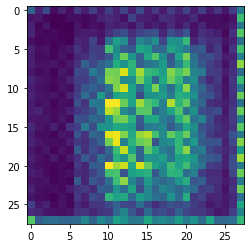

Finished epoch 1 in 1 minutes and 24 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  12.168313 
 Discriminator loss:  6.1017632


  0%|          | 0/32 [00:00<?, ?it/s]

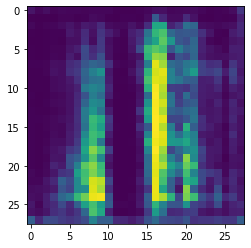

Finished epoch 2 in 1 minutes and 14 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  9.501773 
 Discriminator loss:  9.567358


  0%|          | 0/32 [00:00<?, ?it/s]

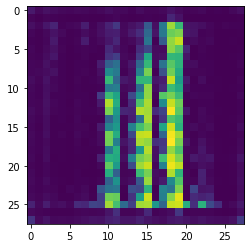

Finished epoch 3 in 1 minutes and 25 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  9.944883 
 Discriminator loss:  11.159606


  0%|          | 0/32 [00:00<?, ?it/s]

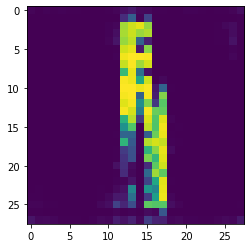

Finished epoch 4 in 1 minutes and 24 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  12.254231 
 Discriminator loss:  12.222675


  0%|          | 0/32 [00:00<?, ?it/s]

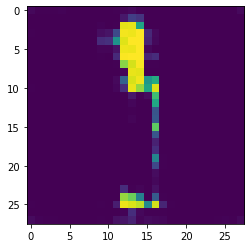

Finished epoch 5 in 1 minutes and 14 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  2.6222472 
 Discriminator loss:  14.394448


  0%|          | 0/32 [00:00<?, ?it/s]

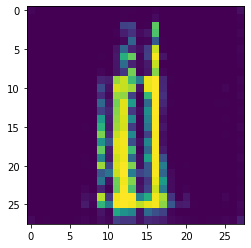

Finished epoch 6 in 1 minutes and 14 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  0.0013266632 
 Discriminator loss:  15.431449


  0%|          | 0/32 [00:00<?, ?it/s]

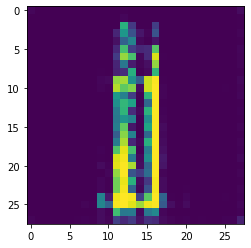

Finished epoch 7 in 1 minutes and 13 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  0.0005520628 
 Discriminator loss:  15.426934


  0%|          | 0/32 [00:00<?, ?it/s]

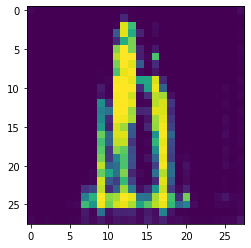

Finished epoch 8 in 1 minutes and 24 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  0.00029789336 
 Discriminator loss:  15.427006


  0%|          | 0/32 [00:00<?, ?it/s]

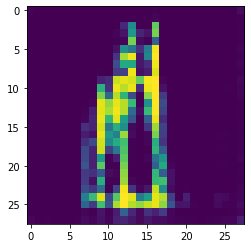

Finished epoch 9 in 1 minutes and 14 seconds.


  0%|          | 0/313 [00:00<?, ?it/s]

 Generator loss:  0.00016867832 
 Discriminator loss:  15.425995


  0%|          | 0/32 [00:00<?, ?it/s]

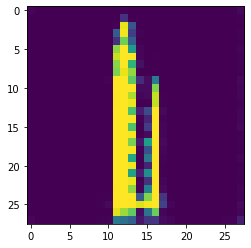

Finished epoch 10 in 1 minutes and 25 seconds.


In [15]:
#Training
tf.keras.backend.clear_session()
Model = GAN(BATCH_SIZE, LEARNING_RATE, DROPOUT_AMOUNT);
Model.train(train_ds, test_ds, N_EPOCHS, N_FAKE_DATA)